In [1]:
# Algoritmo base
# https://www.cs.utexas.edu/~flame/Notes/NotesOnCholReal.pdf

# Alterações feitas:

# A matriz L = zero(A) está sendo criada fora da função
# As alterações estão sendo feitas na própria matriz A
# Utilizar .= e .-=, operações in-place, otimizaram a alocação
# import Pkg
# Pkg.add("BenchmarkTools")

In [615]:
using LinearAlgebra
using LinearAlgebra.LAPACK
using LinearAlgebra.BLAS
using BenchmarkTools # Biblioteca para medir o tempo de execução
using Plots

In [616]:
##### Cholesky Nível 2

# Algoritmo do livro (applied numerical linear algebra)
function  Cholesky_factorize(A::Matrix{Float64})
    # A: Matriz a ser fatorada
    
    # Número de linhas (1 alloc)
    m = size(A, 1)
    
    L = zeros(Float64, m, m)
    
    # Loop principal
    for j in 1:m
        
        # Somatório de Ljk ao quadrado
        sumLjk::Float64 = 0.0
        
        for k in 1:j-1
            sumLjk += L[j, k]*L[j, k]
        end

        # Alterações na diagonal de L
         L[j, j] = sqrt(A[j, j] - sumLjk)

        # Segundo loop principal
        for i in j+1:m
            
            # Somatório do produto Lik e Ljk
            sumLikLjk::Float64 = 0.0
             for k in 1:j-1
                sumLikLjk += L[i, k]*L[j, k]
            end

            # Alterações
             L[i, j] = (A[i, j] - sumLikLjk)/L[j, j]
        end
    end

    return L
end

Cholesky_factorize (generic function with 2 methods)

In [617]:
@views function blocked_cholesky!(A::Matrix{Float64}, nb::Int64)
    # A: Matriz que será fatorada (será alterada)
    # nb: Tamanho do bloco
    
    n = size(A, 1)
    LowerTriangular(A)
    
    for j = 1:nb:n
        b = min(n - j + 1, nb)
        
        # Fatoração Cholesky do bloco A[j:j+b-1, j:j+b-1]
        Ajj = A[j:j+b-1, j:j+b-1]
        info = LAPACK.potrf!('L', Ajj)

        
        if j + b <= n
            A21 = A[j+b:n, j:j+b-1]
            # Passo 2: triangular solve
            BLAS.trsm!('R', 'L', 'T', 'N', 1.0, Ajj, A21)
        end

        
        if j + b <= n
            A21 = A[j+b:n, j:j+b-1]
            A22 = A[j+b:n, j+b:n]
            # Atualização simétrica - SYRK
            BLAS.syrk!('L', 'N', -1.0, A21, 1.0, A22)
        end
    end
    
    # Zera a parte superior (já que estamos usando 'L')
    for i in 1:n
        for j in i+1:n
            A[i, j] = 0.0
        end
    end
    

    return A
end


blocked_cholesky! (generic function with 1 method)

In [628]:
# TESTE DE TEMPO E ALOCAÇÃO

n = 1547 # Ordem nxn
nb = 1024 # Tamanho do bloco
X = rand(n, n)
A = X*X'

# Cópias
B = copy(A)
C = copy(A)
D = copy(A)

print("Tempos de execução e alocações: \n\n")
@time cholesky(B) # Função nativa
@time Cholesky_factorize(C) # Demora mais (nível 2)
@time blocked_cholesky!(D, nb) # Lembrar de alterar o tamanho do bloco (nível 3)

print("-----------------------------------------------------------------------------")

Tempos de execução e alocações: 

  0.050216 seconds (6 allocations: 18.259 MiB, 41.32% gc time)
  0.443194 seconds (2 allocations: 18.259 MiB)
  0.023602 seconds (5 allocations: 320 bytes)
-----------------------------------------------------------------------------

In [330]:
# COMPARAÇÃO DAS IGUALDADES ENTRE AS MATRIZES

n = 2000 # Ordem nxn
nb = 1024 # Tamanho do bloco
X = rand(n, n)
A = X*X'

# Cópias
B = copy(A)
C = copy(A)

L = cholesky(B).L
blocked_cholesky!(C, nb) # modifica C

display(norm(L - C)) # Espera-se uma norma muito pequena ! ! ! ! 

1.1691949762393355e-9

In [141]:
# COMPARAÇÃO DAS NORMAS DOS ERROS

n = 1200 # Ordem nxn
nb = 512 # Tamanho do bloco
X = rand(n, n)
A = X*X'

# Cópias
B = copy(A)
C = copy(A)
D = copy(A)

L = cholesky(B).L
blocked_cholesky!(C, nb) # modifica C
M = Cholesky_factorize(D)

display(norm(A - L*L'))
display(norm(A - C*C'))
display(norm(A - M*M'))

1.2689967027454484e-11

3.1578450566412415e-11

3.3346517157942784e-10

In [640]:
function graph_time(I1::Int64, I2::Int64, p::Int64)
    # I1: Início do intervalo
    # I2: Fim do intervalo
    # p: Quantidade para média do tempo
    
    grph = plot(title = "Tempo de execução \n p: $p" , 
        xlabel = "Ordem da matriz (n)", 
        ylabel= "Tempo de execução (s)")

    T1 = zeros(I2 - I1) 
    T2 = zeros(I2 - I1)
    N = collect(I1:(I2-1)) # Vai até I2 + 1, daí subtraí 1.

    for (i, n) in enumerate(N)

        # potência de dois mais perto da metade de n/2
        nb = 2^Int64(floor(log2(ceil(n/2))))
        X = rand(n, n)

        for _ in 1:p # Loop que faz a média dos tempos para uma mesma ordem "n"

            A = X*X'
            B = copy(A)

            # Tempo médio - @elapsed marca o tempo
            T1[i] += (@elapsed cholesky(A))/p
            T2[i] += (@elapsed blocked_cholesky!(B, nb))/p
        end
    end

    plot!(N, T1, label = "Cholesky nativa")
    plot!(N, T2, label = "Cholesky blocado")
    
    display(grph)
end

graph_time (generic function with 3 methods)

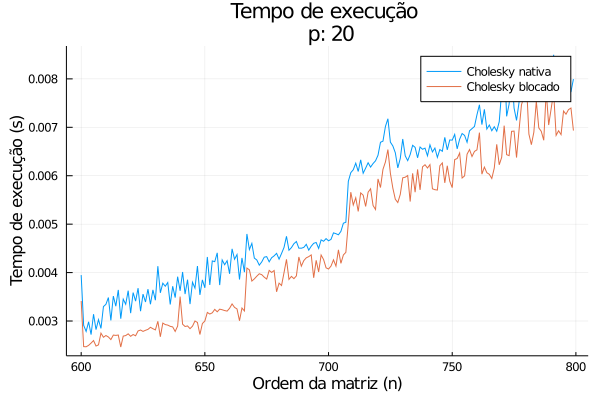

In [645]:
graph_time(600, 800, 20)